In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.signal as signal
import scipy.stats as stats
from scipy.interpolate import spline
from statsmodels.robust.scale import mad
import scipy.io as sio
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import hsutil
from importlib import reload
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-paper')

In [2]:
path = 'D:\\Dropbox\\labwork\\behavior\\heatseeking-pilot\\'
orl = ['20180627_2',
       '20180628_2',
       '20180629_3',
       '20180711_1',
       '20180712_1',
       '20180713_2']
orlgr3 = ['20180627_3',
       '20180628_1',
       '20180629_1',
       '20180711_2',
       '20180712_2',
       '20180713_1']
gr3 = ['20180627_1',
       '20180628_3',
       '20180629_2',
       '20180711_3',
       '20180712_3',
       '20180713_3']
path2 = 'F:\\heatseeking-pilot\\'
air = ['20161013_orl1004-1',
      '20161020_orl1011-0',
      '20161021_orl1011-0',
      '20161021_orl1011-1',
      '20161023_orl1011-0',
      '20161110_orl1101-0']

In [8]:
aRtot

array([[ 0.        ,  0.        ,  0.        , ...,  0.0212766 ,
         0.0212766 ,  0.0212766 ],
       [ 0.04166667,  0.04166667,  0.04166667, ...,  0.0625    ,
         0.08333333,  0.0625    ],
       [ 0.13333333,  0.13333333,  0.13333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04081633,  0.04081633,  0.04081633, ...,  0.04081633,
         0.04081633,  0.04081633],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.22222222,  0.22222222],
       [ 0.04255319,  0.04255319,  0.04255319, ...,  0.0212766 ,
         0.0212766 ,  0.0212766 ]])

In [7]:
reload(hsutil)
[cRtot,cRtemp] = hsutil.itergetmat(path,orl)
[hRtot,hRtemp] = hsutil.itergetmat(path,orlgr3)
[gRtot,gRtemp] = hsutil.itergetmat(path,gr3)
[aRtot,_] = hsutil.itergetmat(path2,air)
Rtemp = sio.loadmat(path+'Rtemp.mat')['Rtemp']

In [48]:
def plot_trace(t,tot,c='0.5',ax=None,label=None,indiv=True,med=False):
    if ax is None:
        ax = plt.gca()
    avg = np.nanmean(tot,axis=0)
    if indiv:
        for trace in tot:
            ax.plot(t,trace,c=c,alpha=0.2)
    if med:
        medabs = mad(tot,c=1,axis=0)
        ax.fill_between(t,avg-medabs,avg+medabs,alpha=0.4,facecolor=c,edgecolor=None)
    ax.plot(t,avg,alpha=0.9,lw=0.75,c=c,label=label)
    return ax

def norm_trace(gRtot,heat=range(360,9000,720),baserange=[120,180]):
    n,_ = gRtot.shape
    gNorm = np.empty([n,len(heat),720])
    for i in range(n):
        trace = gRtot[i,:]
        for j in range(len(heat)):
            baseline = np.mean(trace[heat[j]+baserange[0]:heat[j]+baserange[1]])
            if baseline <= 0.01:
                gNorm[i,j,:] = np.nan
            else:
                gNorm[i,j,:] = trace[heat[j]:heat[j]+720]*(1/baseline)
    return gNorm

def Rpts(gNorm,a=270,b=360):
    n,m,_ = gNorm.shape
    gRpts = np.empty([n,m])
    for i in range(n):
        for j in range(m):
            gRpts[i,j] = np.mean(gNorm[i,j,a:b])
    gRpts = np.transpose(gRpts)*100
    return gRpts

def sample_power_difftest(d, s, power=0.8, sig=0.05):
    z = stats.norm.isf([sig/2]) 
    zp = -1 * stats.norm.isf([power])
    n = (2*(s**2)) * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

def calc_power(n_per_group, group_means, group_sigmas, n_sims=10000):
    n_groups = len(group_means)
    data = np.empty([n_sims, n_per_group, n_groups])
    data.fill(np.nan)
    
    for i_group in range(n_groups):
        data[:,:,i_group] = np.random.normal(loc=group_means[i_group],
                                             scale=group_sigmas[i_group],
                                             size=[n_sims, n_per_group])
    result = stats.ttest_ind(data[:, :, 0],data[:, :, 1],axis=1)
    sim_p = result[1]

    # number of simulations where the null was rejected
    n_rej = np.sum(sim_p < 0.05)
    prop_rej = n_rej / float(n_sims)
    print("Power: ", prop_rej)
    
    return prop_rej

def kruskal(fda):
    print(stats.kruskal(*(d for d in fda)).pvalue)
    ntests = 0
    for i in range(len(fda)):
        printstr = ''
        for j in range(i+1,len(fda)):
            printstr = printstr + str(round(stats.mannwhitneyu(fda[i],fda[j],alternative='two-sided').pvalue,4)) + '\t'
            ntests += 1
        print(printstr)
    print(0.05/ntests)
    return stats.kruskal(*(d for d in fda)).pvalue

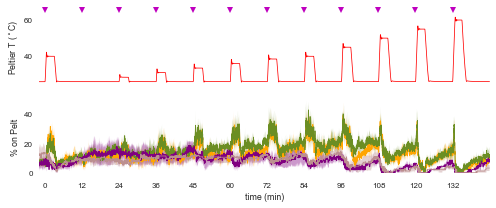

In [41]:
reload(hsutil)

t = np.array(range(-540,8640)) / 60.

f,ax = plt.subplots(2,sharex=True)
f.set_size_inches(7,3)

ax[0] = hsutil.plot_trace(t,Rtemp,c='r',ax=ax[0],indiv=False,med=True)
ax[0].set_xlim(min(t),max(t))
ax[0].plot(range(0,144,12),[65]*12,'mv')
ax[0].set_xticks(range(0,144,12))
ax[0].set_ylabel('Peltier T ($^\circ$C)')

ax[1] = hsutil.plot_trace(t,cRtot*100,c='orange',ax=ax[1],indiv=False,med=True)


ax[1] = hsutil.plot_trace(t,hRtot*100,c='olivedrab',ax=ax[1],indiv=False,med=True)

ax[1] = hsutil.plot_trace(t,gRtot*100,c='purple',ax=ax[1],indiv=False,med=True)

ax[1] = hsutil.plot_trace(t,aRtot*100,c='rosybrown',ax=ax[1],indiv=False,med=True)
#ax[2].set_yticks(np.arange(0,21,5))
ax[1].set_ylabel('% on Pelt')
#ax[1].text(136,0.38,'n=3',color='darkred')

ax[-1].set_xlabel('time (min)')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.xaxis.grid(False)
    a.yaxis.grid(False)
    
ax[1].set_xlim([-2,8640/60])

plt.tight_layout()
plt.savefig('gr3_plusair_trace.pdf')

In [43]:
gNorm = norm_trace(gRtot)
hNorm = norm_trace(hRtot)
cNorm = norm_trace(cRtot)
aNorm = norm_trace(aRtot)

C:\Users\liber\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median for 300 results
  r = func(a, **kwargs)


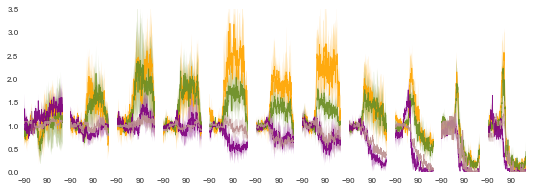

In [49]:
labels = ['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
          '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']

n,m,_ = gNorm.shape
f,ax = plt.subplots(1,m-1,sharex=True,sharey=True)
f.set_size_inches([9,3])
for i in range(1,m):
    plot_trace(range(-90,210),cNorm[:,i,90:390],c='orange',ax=ax[i-1],indiv=False,med=True)
    plot_trace(range(-90,210),hNorm[:,i,90:390],c='olivedrab',ax=ax[i-1],indiv=False,med=True)
    plot_trace(range(-90,210),gNorm[:,i,90:390],c='purple',ax=ax[i-1],indiv=False,med=True)
    plot_trace(range(-90,210),aNorm[:,i,90:390],c='rosybrown',ax=ax[i-1],indiv=False,med=True)
    ax[i-1].set_xticks(range(-90,210,180))
    ax[i-1].grid(False)
    ax[i-1].spines['top'].set_visible(False)
    ax[i-1].spines['right'].set_visible(False)
    ax[i-1].spines['left'].set_visible(False)
    ax[i-1].spines['bottom'].set_visible(False)
ax[0].set_ylim([0,3.5])
ax[1].set_xlim([-90,210])
#plt.tight_layout()
plt.savefig('gr3_plusair_timecomp.pdf')

In [44]:
aRtot[5,:]

array([ 0.04255319,  0.04255319,  0.04255319, ...,  0.0212766 ,
        0.0212766 ,  0.0212766 ])

In [50]:
gHeat = Rpts(gNorm)[1:]
hHeat = Rpts(hNorm)[1:]
cHeat = Rpts(cNorm)[1:]
aHeat = Rpts(aNorm)[1:]

In [16]:
gRpts = hsutil.avgheat(gRtot)[1:]
hRpts = hsutil.avgheat(hRtot)[1:]
cRpts = hsutil.avgheat(cRtot)[1:]
aRpts = hsutil.avgheat(aRtot)[1:]

In [17]:
gBase = hsutil.avgheat(gRtot,sampling=range(1170,8640,720))
hBase = hsutil.avgheat(hRtot,sampling=range(1170,8640,720))
cBase = hsutil.avgheat(cRtot,sampling=range(1170,8640,720))
aBase = hsutil.avgheat(aRtot,sampling=range(1170,8640,720))

In [9]:
dat = sio.loadmat(path+'gr3_on_dot.mat')
cDot = dat['orldot'][1:]
gDot = dat['gr3dot'][1:]
hDot = dat['orlgr3dot'][1:]

In [33]:
gBase

array([[ 0.08311111,  0.21955556,  0.08231293,  0.08356481,  0.03564815,
         0.16597222],
       [ 0.04333333,  0.25555556,  0.16213152,  0.14282407,  0.05162037,
         0.18935185],
       [ 0.04155556,  0.26044444,  0.09795918,  0.14490741,  0.03310185,
         0.13958333],
       [ 0.04      ,  0.21733333,  0.16077098,  0.15925926,  0.05509259,
         0.20601852],
       [ 0.08155556,  0.25244444,  0.14399093,  0.16805556,  0.0900463 ,
         0.11319444],
       [ 0.04288889,  0.13088889,  0.10634921,  0.13055556,  0.07060185,
         0.20486111],
       [ 0.08222222,  0.15044444,  0.20566893,  0.05810185,  0.03611111,
         0.19930556],
       [ 0.07288889,  0.10066667,  0.10589569,  0.1275463 ,  0.05231481,
         0.17453704],
       [ 0.09511111,  0.05666667,  0.15895692,  0.06805556,  0.01666667,
         0.09444444],
       [ 0.06      ,  0.04177778,  0.15510204,  0.03981481,  0.04375   ,
         0.0412037 ],
       [ 0.02      ,  0.07911111,  0.07959184,  0.

C:\Users\liber\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


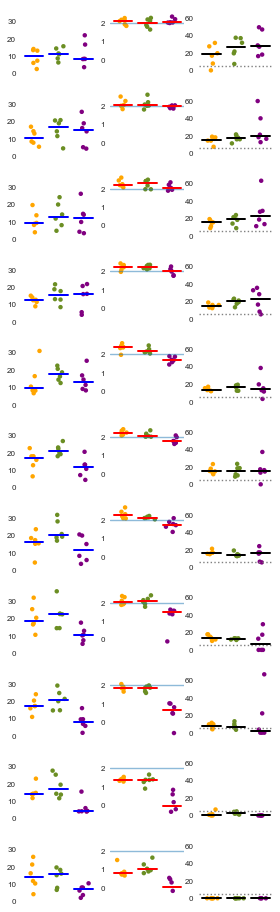

In [29]:
reload(hsutil)
f,ax = plt.subplots(11,3,sharex=True,sharey='col')
pc = ['orange','olivedrab','purple']
f.set_size_inches(4.5,16.5)
for i in range(11):
    ax[i][0] = hsutil.dotplot(np.vstack([cBase[i],hBase[i],gBase[i]])*100,pc=pc,mc='b',ax=ax[i][0],fixline=False)
    ax[i][1].axhline(2,alpha=0.5)
    ax[i][1] = hsutil.dotplot(np.log10(np.vstack([cHeat[i],hHeat[i],gHeat[i]])),pc=pc,mc='r',ax=ax[i][1],fixline=False)
    ax[i][2] = hsutil.dotplot(np.vstack([cDot[i],hDot[i],gDot[i]])*100,pc=pc,mc='k',ax=ax[i][2],fixline=True)
    for a in ax[i]:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.xaxis.grid(False)
        a.yaxis.grid(False)
ax[-1][-1].set_xlim(-0.5,2.5)
plt.savefig('gr3dotplots_base-heat-dot.pdf')

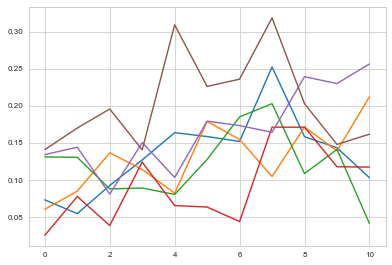

In [34]:
plt.plot(cBase)

C:\Users\liber\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
C:\Users\liber\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


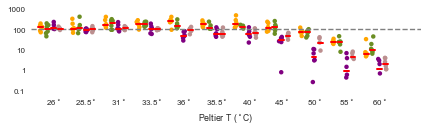

In [51]:
reload(hsutil)
f,ax = plt.subplots(1)
f.set_size_inches(7,1.5)
ax.axhline(2,c='0.5',ls='--')
ax = hsutil.dotplot(np.log10(cHeat),mc='r',pos=range(0,60,5),pc=['orange'],fixline=False,ax=ax)
ax = hsutil.dotplot(np.log10(hHeat),mc='r',pos=range(1,60,5),pc=['olivedrab'],fixline=False,ax=ax)
ax = hsutil.dotplot(np.log10(gHeat),mc='r',pos=range(2,60,5),pc=['purple'],fixline=False,ax=ax)
ax = hsutil.dotplot(np.log10(aHeat),mc='r',pos=range(3,60,5),pc=['rosybrown'],fixline=False,ax=ax)
ax.set_xlim(-1.5,58.5)
ax.set_yticks(np.arange(-1,4,1))
ax.set_yticklabels([0.1,1,10,100,1000])
#ax.set_yticks(np.arange(0,900,200))
ax.set_xticks(np.arange(2,60,5))
ax.set_xticklabels(['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$'])
#ax.set_ylabel('mean proportion during heat')
ax.set_xlabel('Peltier T ($^\circ$C)')
ax.xaxis.grid(False)
ax.yaxis.grid(False)
#ax.scatter([0.4,1.4,2.4,3.4,4.4,5.4],cRpts,c='0.75',edgecolor='none')
plt.savefig('gr3_plusair_vp.pdf')

C:\Users\liber\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


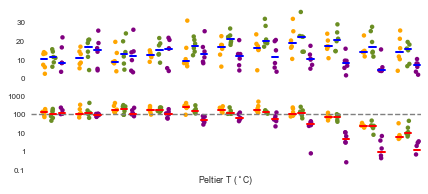

In [37]:
reload(hsutil)
f,ax = plt.subplots(2,1,sharex=True)
f.set_size_inches(7,3)
#ax.axhline(2,c='0.5',ls='--')
ax[0] = hsutil.dotplot(cBase*100,mc='b',pos=range(0,44,4),pc=['orange'],fixline=False,ax=ax[0])
ax[0] = hsutil.dotplot(hBase*100,mc='b',pos=range(1,44,4),pc=['olivedrab'],fixline=False,ax=ax[0])
ax[0] = hsutil.dotplot(gBase*100,mc='b',pos=range(2,44,4),pc=['purple'],fixline=False,ax=ax[0])

ax[0].set_yticks(np.arange(0,40,10))
ax[1].axhline(2,c='0.5',ls='--')
ax[1] = hsutil.dotplot(np.log10(cHeat),mc='r',pos=range(0,48,4),pc=['orange'],fixline=False,ax=ax[1])
ax[1] = hsutil.dotplot(np.log10(hHeat),mc='r',pos=range(1,48,4),pc=['olivedrab'],fixline=False,ax=ax[1])
ax[1] = hsutil.dotplot(np.log10(gHeat),mc='r',pos=range(2,48,4),pc=['purple'],fixline=False,ax=ax[1])
ax[1].set_yticks(np.arange(-1,4,1))
ax[1].set_yticklabels([0.1,1,10,100,1000])
ax[1].set_xlim(-1.5,42.5)
#ax.set_yticklabels([0.1,1,10,100,1000])
#ax.set_yticks(np.arange(0,900,200))
#ax.set_ylabel('mean proportion during heat')
ax[1].set_xlabel('Peltier T ($^\circ$C)')
ax[0].xaxis.grid(False)
ax[0].yaxis.grid(False)
ax[1].xaxis.grid(False)
ax[1].yaxis.grid(False)
#ax.scatter([0.4,1.4,2.4,3.4,4.4,5.4],cRpts,c='0.75',edgecolor='none')
plt.savefig('gr3_baseline.pdf')

In [44]:
reload(hsutil)
hsutil.multiWilcoxon(hRpts,gRpts)

RanksumsResult(statistic=1.6012815380508714, pvalue=0.10931457620866636)
RanksumsResult(statistic=-0.80064076902543568, pvalue=0.42333964158244364)
RanksumsResult(statistic=1.281025230440697, pvalue=0.20018480417757911)
RanksumsResult(statistic=1.281025230440697, pvalue=0.20018480417757911)
RanksumsResult(statistic=2.2417941532712198, pvalue=0.024974679293054237)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.2417941532712198, pvalue=0.024974679293054237)
RanksumsResult(statistic=2.7221786146864813, pvalue=0.0064853079706713671)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
p_adj = 0.004166666666666667


In [41]:
hsutil.multiWilcoxon(hRpts,gRpts)

RanksumsResult(statistic=1.6012815380508714, pvalue=0.10931457620866636)
RanksumsResult(statistic=-0.80064076902543568, pvalue=0.42333964158244364)
RanksumsResult(statistic=1.281025230440697, pvalue=0.20018480417757911)
RanksumsResult(statistic=1.281025230440697, pvalue=0.20018480417757911)
RanksumsResult(statistic=2.2417941532712198, pvalue=0.024974679293054237)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.2417941532712198, pvalue=0.024974679293054237)
RanksumsResult(statistic=2.7221786146864813, pvalue=0.0064853079706713671)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
p_adj = 0.004166666666666667


In [42]:
hsutil.multiWilcoxon(cRpts,gRpts)

RanksumsResult(statistic=1.4411533842457842, pvalue=0.14954135458461512)
RanksumsResult(statistic=-0.16012815380508713, pvalue=0.87278012379391179)
RanksumsResult(statistic=0.96076892283052273, pvalue=0.33666836761003882)
RanksumsResult(statistic=1.7614096918559585, pvalue=0.078169085824283446)
RanksumsResult(statistic=1.6012815380508714, pvalue=0.10931457620866636)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.7221786146864813, pvalue=0.0064853079706713671)
RanksumsResult(statistic=2.5620504608813941, pvalue=0.010405619868873589)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
RanksumsResult(statistic=2.8823067684915684, pvalue=0.0039477518569034573)
p_adj = 0.004166666666666667


In [43]:
hsutil.multiWilcoxon(cRpts,hRpts)

RanksumsResult(statistic=-0.48038446141526137, pvalue=0.63095404118417076)
RanksumsResult(statistic=0.48038446141526137, pvalue=0.63095404118417076)
RanksumsResult(statistic=-0.32025630761017426, pvalue=0.74877404170654716)
RanksumsResult(statistic=0.48038446141526137, pvalue=0.63095404118417076)
RanksumsResult(statistic=-0.32025630761017426, pvalue=0.74877404170654716)
RanksumsResult(statistic=1.281025230440697, pvalue=0.20018480417757911)
RanksumsResult(statistic=1.7614096918559585, pvalue=0.078169085824283446)
RanksumsResult(statistic=1.1208970766356099, pvalue=0.26233167540835722)
RanksumsResult(statistic=-0.16012815380508713, pvalue=0.87278012379391179)
RanksumsResult(statistic=0.0, pvalue=1.0)
RanksumsResult(statistic=0.64051261522034852, pvalue=0.52183939033361537)
RanksumsResult(statistic=-1.9215378456610455, pvalue=0.054663935891675154)
p_adj = 0.004166666666666667


In [62]:
a = aHeat[8]
a = a[~np.isnan(a)]
a

array([ 35.57312253,   8.88888889,  40.18518519,  22.13883677,   0.        ])

In [65]:
# normalized

labels = ['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']
for i in range(11):
    print(labels[i])
    a = aHeat[i]
    a = a[~np.isnan(a)]
    k = kruskal([cHeat[i],hHeat[i],gHeat[i],a])
    print(k*11)

26$^\circ$
0.660902384706
0.6889	0.9362	0.4712	
0.4712	0.9362	
0.2298	

0.008333333333333333
7.26992623176
28.5$^\circ$
0.546536782041
0.8102	0.3785	0.5752	
0.2298	0.4712	
0.5752	

0.008333333333333333
6.01190460245
31$^\circ$
0.0783220306684
0.6889	0.0927	0.0202	
0.2298	0.1282	
0.9362	

0.008333333333333333
0.861542337352
33.5$^\circ$
0.0125075043504
0.8102	0.1282	0.0306	
0.0306	0.0051	
0.9362	

0.008333333333333333
0.137582547855
36$^\circ$
0.000526787910629
0.2298	0.0051	0.0202	
0.0051	0.0131	
0.0131	

0.008333333333333333
0.00579466701692
38.5$^\circ$
0.00207875906743
0.0927	0.0082	0.0051	
0.0306	0.0306	
0.6889	

0.008333333333333333
0.0228663497417
40$^\circ$
0.00124622617662
0.298	0.0131	0.0051	
0.0082	0.0082	
0.5752	

0.008333333333333333
0.0137084879429
45$^\circ$
0.000747649139029
0.9362	0.0051	0.0081	
0.0051	0.0225	
0.0358	

0.008333333333333333
0.00822414052932
50$^\circ$
0.000912740008928
0.9362	0.0051	0.0081	
0.0051	0.0137	
0.2353	

0.008333333333333333
0.0100401400982
55$

In [24]:
aNorm

array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.33333333,  1.33333333,  1.33333333, ...,  5.33333333,
          5.33333333,  5.33333333],
        [ 1.15942029,  1.15942029,  1.15942029, ...,  0.57971014,
          0.57971014,  0.57971014],
        ..., 
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.51724138,  0.51724138,  0.51724138, ...,  1.03448276,
          1.03448276,  1.03448276],
        [ 1.        ,  1.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.63829787,  0.63829787,  0.63829787, ...,  0.38297872,
          0.38297872,  0.38297872],
        [ 1.05882353,  1.05882353,  1.05882353, ...,  1.05882353,
          1.05882353,  1.05882353],
        [ 0.73770492,  0.73770492,  0.73770492, ...,  1.47540984,
          1.2295082 ,  1.2295082 ],
        ..., 
        [ 0.4743083 ,  0.4743083 ,  0.4743083 , ...,

In [38]:
labels = ['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']
for i in range(11):
    print(labels[i])
    k = kruskal(np.vstack([cBase[i],hBase[i],gBase[i]]))
    print(k*11)

26$^\circ$
0.65252842025
0.4712	0.5752	
0.6889	

0.016666666666666666
7.17781262275
28.5$^\circ$
0.557219900998
0.298	0.6889	
0.6889	

0.016666666666666666
6.12941891098
31$^\circ$
0.687791866907
0.4712	0.6889	
0.6889	

0.016666666666666666
7.56571053597
33.5$^\circ$
0.413523499395
0.2298	0.3785	
0.9362	

0.016666666666666666
4.54875849335
36$^\circ$
0.263597138116
0.1735	0.4712	
0.298	

0.016666666666666666
2.89956851927
38.5$^\circ$
0.0179971141372
0.0306	0.298	
0.0202	

0.016666666666666666
0.197968255509
40$^\circ$
0.069078301055
0.0656	0.4712	
0.0656	

0.016666666666666666
0.759861311605
45$^\circ$
0.0232782945229
0.8102	0.0453	
0.0131	

0.016666666666666666
0.256061239752
50$^\circ$
0.00968257984213
0.4712	0.0131	
0.0131	

0.016666666666666666
0.106508378263
55$^\circ$
0.0292415761197
0.6889	0.0453	
0.0202	

0.016666666666666666
0.321657337317
60$^\circ$
0.0621765240221
0.8102	0.0453	
0.0656	

0.016666666666666666
0.683941764243


In [29]:
# baselines

labels = ['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']
for i in range(11):
    print(labels[i])
    kruskal(np.vstack([cRpts[i],hRpts[i],gRpts[i]]))

26$^\circ$
0.932230256391
0.6889	0.9362	
0.9362	

0.016666666666666666
28.5$^\circ$
0.197921846484
0.1282	0.6889	
0.1735	

0.016666666666666666
31$^\circ$
0.121103332392
0.5752	0.1735	
0.0656	

0.016666666666666666
33.5$^\circ$
0.0147520345664
0.298	0.0656	
0.0082	

0.016666666666666666
36$^\circ$
0.00412277800338
0.5752	0.0082	
0.0051	

0.016666666666666666
38.5$^\circ$
0.00332062473959
0.8102	0.0051	
0.0051	

0.016666666666666666
40$^\circ$
0.00332062473959
0.8102	0.0051	
0.0051	

0.016666666666666666
45$^\circ$
0.00332062473959
0.8102	0.0051	
0.0051	

0.016666666666666666
50$^\circ$
0.00332062473959
0.8102	0.0051	
0.0051	

0.016666666666666666
55$^\circ$
0.00335958898253
0.9362	0.005	
0.005	

0.016666666666666666
60$^\circ$
0.00125652197321
0.0453	0.005	
0.005	

0.016666666666666666


In [59]:
0.05/12

0.004166666666666667

In [17]:
# violinplots for on dot
dat = sio.loadmat(path+'gr3_on_dot.mat')
orldot = dat['orldot']
gr3dot = dat['gr3dot']
orlgr3dot = dat['orlgr3dot']
orldotn = dat['orldotn']
gr3dotn = dat['gr3dotn']
orlgr3dotn = dat['orlgr3dotn']

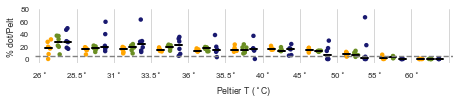

In [24]:
reload(hsutil)
f,ax = plt.subplots(1)
f.set_size_inches(7.5,1)
ax = hsutil.dotplot(orldot[1:,:]*100,mc='k',pos=range(0,48,4),pc=['orange'],fixline=False,ax=ax)
ax = hsutil.dotplot(orlgr3dot[1:,:]*100,mc='k',pos=range(1,48,4),pc=['olivedrab'],fixline=False,ax=ax)
ax = hsutil.dotplot(gr3dot[1:,:]*100,mc='k',pos=range(2,48,4),pc=['midnightblue'],fixline=False,ax=ax)
ax.set_xlim(-1.5,43.5)
#ax.set_ylim(0,0.5)
ax.axhline(5.42,c='0.5',ls='--')
ax.set_yticks(np.arange(0,100,20))
ax.set_xticks(np.arange(-1,44,4))
ax.set_xticklabels(['26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$'])
ax.set_ylabel('% dot/Pelt')
ax.set_xlabel('Peltier T ($^\circ$C)')
ax.yaxis.grid(False)
#ax.scatter([0.4,1.4,2.4,3.4,4.4,5.4],cRpts,c='0.75',edgecolor='none')
plt.savefig('gr3_dot_ratio.pdf')

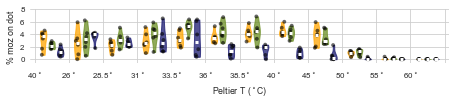

In [21]:
reload(hsutil)
f,ax = plt.subplots(1)
f.set_size_inches(7.5,1)
ax = hsutil.violinplot(orldotn*100,fc=['orange']*12,ec=['orange']*12,mc='w',jitter=0.1,pos=range(0,48,4),pc='k',fixline=False,ax=ax)
ax = hsutil.violinplot(orlgr3dotn*100,fc=['olivedrab']*12,ec=['olivedrab']*12,mc='w',jitter=0.1,pos=range(1,48,4),pc='k',fixline=False,ax=ax)
ax = hsutil.violinplot(gr3dotn*100,fc=['midnightblue']*12,ec=['midnightblue']*12,mc='w',jitter=0.1,pos=range(2,48,4),pc='k',fixline=False,ax=ax)
ax.set_xlim(-1.5,47.5)
#ax.set_ylim(0,0.5)
ax.set_yticks(np.arange(0,9,2))
ax.set_xticks(np.arange(-1,48,4))
ax.set_xticklabels(['40$^\circ$','26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$'])
ax.set_ylabel('% moz on dot')
ax.set_xlabel('Peltier T ($^\circ$C)')
#ax.xaxis.grid(False)
#ax.scatter([0.4,1.4,2.4,3.4,4.4,5.4],cRpts,c='0.75',edgecolor='none')
plt.savefig('gr3_dot_abs.pdf')

In [22]:
orldot[11]

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [36]:
labels = ['40$^\circ$','26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']
for i in range(12):
    print(labels[i])
    k = kruskal(np.vstack([orldot[i],orlgr3dot[i],gr3dot[i]]))
    print(k)

40$^\circ$


NameError: name 'orldot' is not defined

In [23]:
labels = ['40$^\circ$','26$^\circ$','28.5$^\circ$','31$^\circ$','33.5$^\circ$','36$^\circ$',
                    '38.5$^\circ$','40$^\circ$','45$^\circ$','50$^\circ$','55$^\circ$','60$^\circ$']
for i in range(12):
    print(labels[i])
    hsutil.friedman(np.vstack([orldotn[i],orlgr3dotn[i],gr3dotn[i]]))

40$^\circ$
0.114558843993
0.2623	0.0374	
0.0163	

0.016666666666666666
26$^\circ$
0.135335283237
0.5218	0.1495	
0.5218	

0.016666666666666666
28.5$^\circ$
0.0301973834223
0.1093	0.5218	
0.2623	

0.016666666666666666
31$^\circ$
0.311403223915
0.2623	1.0	
0.4233	

0.016666666666666666
33.5$^\circ$
0.114558843993
0.0163	0.7488	
0.2623	

0.016666666666666666
36$^\circ$
0.0094035625515
0.1093	0.0039	
0.0039	

0.016666666666666666
38.5$^\circ$
0.0421438435093
0.631	0.0039	
0.0163	

0.016666666666666666
40$^\circ$
0.0094035625515
0.631	0.0039	
0.0039	

0.016666666666666666
45$^\circ$
0.0111089965382
1.0	0.0104	
0.0039	

0.016666666666666666
50$^\circ$
0.0094035625515
0.4233	0.0065	
0.0065	

0.016666666666666666
55$^\circ$
0.0219677058894
0.1495	0.0547	
0.0039	

0.016666666666666666
60$^\circ$
nan
1.0	1.0	
1.0	

0.016666666666666666


C:\Users\liber\Anaconda3\lib\site-packages\scipy\stats\stats.py:5127: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
C:\Users\liber\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\liber\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\liber\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [33]:
# running a 2-way ANOVA on these data
temp = [26]*6 + [28.5]*6 + [31]*6 + [33.5]*6 + [36]*6 + [38.5]*6 + [40]*6 + [45]*6 + [50]*6 + [55]*6 + [60]*6
temp = temp*3
genotype = ['orl']*66 + ['orlgr3']*66 + ['gr3']*66
base = pd.DataFrame(data={'residence': np.concatenate([cBase.flat,hBase.flat,gBase.flat]),
                         'temperature': temp, 'genotype': genotype})
heat = pd.DataFrame(data={'residence': np.concatenate([cHeat.flat,hHeat.flat,gHeat.flat]),
                         'temperature': temp, 'genotype': genotype})

In [30]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [32]:
data = base
formula = 'residence ~ C(temperature) + C(genotype) + C(temperature):C(genotype)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

                              sum_sq     df          F        PR(>F)  \
C(temperature)              0.089090   10.0   2.506589  7.895398e-03   
C(genotype)                 0.140211    2.0  19.724371  2.085493e-08   
C(temperature):C(genotype)  0.112553   20.0   1.583356  6.201664e-02   
Residual                    0.586451  165.0        NaN           NaN   

                              eta_sq  omega_sq  
C(temperature)              0.095971  0.057464  
C(genotype)                 0.151039  0.142835  
C(temperature):C(genotype)  0.121246  0.044500  
Residual                         NaN       NaN  


In [34]:
data = heat
formula = 'residence ~ C(temperature) + C(genotype) + C(temperature):C(genotype)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

                                   sum_sq     df          F        PR(>F)  \
C(temperature)              602025.753347   10.0  16.869562  8.687855e-21   
C(genotype)                 227040.152960    2.0  31.809835  2.068017e-12   
C(temperature):C(genotype)  136500.899988   20.0   1.912468  1.447212e-02   
Residual                    588837.159045  165.0        NaN           NaN   

                              eta_sq  omega_sq  
C(temperature)              0.387303  0.363510  
C(genotype)                 0.146063  0.141147  
C(temperature):C(genotype)  0.087816  0.041802  
Residual                         NaN       NaN  


In [29]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

NameError: name 'sm' is not defined